In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

### 1. Load the ct-of-the-neck image

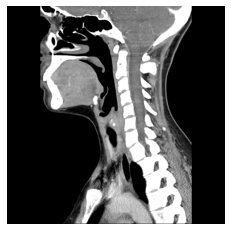

In [2]:
normal_img = cv2.imread('normal-ct-of-the-neck.jpg', 0)
## disable x & y axis
plt.axis('off')
plt.imshow(normal_img, cmap='gray', vmin=normal_img.min(), vmax=normal_img.max())

### 2. Smooth image using gaussian filter

In [3]:
smoothed_img = cv2.GaussianBlur(normal_img,(5,5),0)

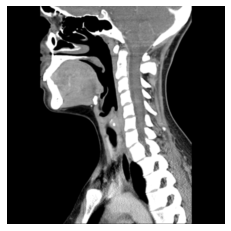

In [4]:
## disable x & y axis
plt.axis('off')
plt.imshow(smoothed_img, cmap='gray', vmin=smoothed_img.min(), vmax=smoothed_img.max())

### 3. Apply Sobel and Prewitt kernels

In [5]:
def apply_filter(img, filter_type):
    # Detect filter type
    if filter_type == 'sobel':
        kernel_x = np.array([[-1, 0, 1], 
                            [-2, 0, 2], 
                            [-1, 0, 1]])

        kernel_y = np.array([[-1, -2, -1], 
                            [0, 0, 0], 
                            [1, 2, 1]])

    elif filter_type == 'prewitt':
        kernel_x = np.array([[-1, -1, -1],
                            [0, 0, 0],
                            [1, 1, 1]])

        kernel_y = np.array([[-1, 0, 1],
                            [-1, 0, 1],
                            [-1, 0, 1]])

    grad_x = cv2.filter2D(img, -1, kernel_x)
    grad_y = cv2.filter2D(img, -1, kernel_y)

    grad = cv2.addWeighted(grad_x, 0.5, grad_y, 0.5, 0)
    grad = grad / grad.max() * 255
    theta = np.arctan2(grad_y, grad_x)

    return grad, theta

#### Sobel

In [6]:
sobel_grad, sobel_theta = apply_filter(smoothed_img, 'sobel')

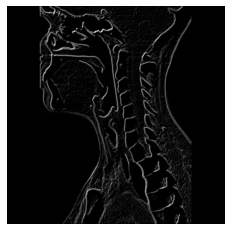

In [7]:
## disable x & y axis
plt.axis('off')
plt.imshow(sobel_grad, cmap='gray', vmin=sobel_grad.min(), vmax=sobel_grad.max())

#### Prewitt

In [8]:
prewitt_grad, prewitt_theta = apply_filter(smoothed_img, 'prewitt')

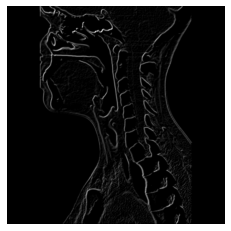

In [9]:
## disable x & y axis
plt.axis('off')
plt.imshow(prewitt_grad, cmap='gray', vmin=prewitt_grad.min(), vmax=prewitt_grad.max())

### 4. Apply non-maximum suppresion

In [10]:
def non_maxima_suppression(img, D):
    # Create a matrix initialized to 0
    Z = np.zeros(img.shape, dtype=np.int32)
    # Identify the edge direction
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    # Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            try:
                q = 255
                r = 255
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

### 5. Apply non-maxima suppression on sobel and prewitt results

In [13]:
nmp_sobel_img = non_maxima_suppression(sobel_grad, sobel_theta)
nmp_prewitt_img = non_maxima_suppression(prewitt_grad, prewitt_theta)

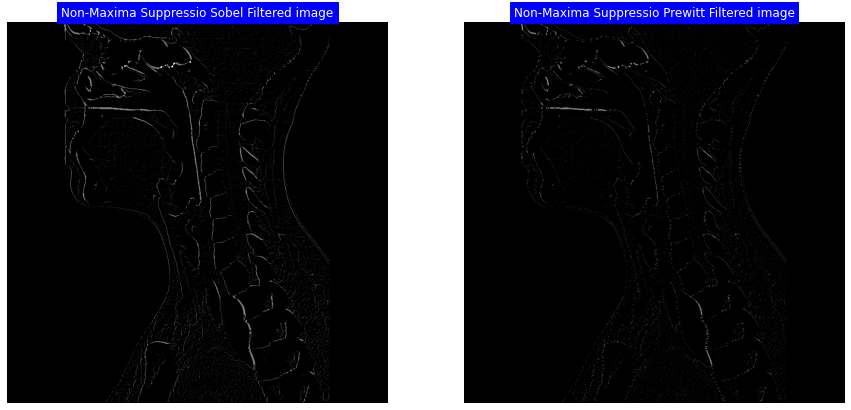

In [21]:
# Plot
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(1, 2)

# original image
ax1 = fig.add_subplot(gs[0, 0])
# ax1.imshow(chest_img, cmap='gray')
ax1.set_title('Non-Maxima Suppressed Sobel Filtered image', color='white', backgroundcolor='blue')
plt.axis('off')
plt.imshow(nmp_sobel_img, cmap='gray', vmin=nmp_sobel_img.min(), vmax=nmp_sobel_img.max())

# filtered image
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Non-Maxima Suppressed Prewitt Filtered image', color='white', backgroundcolor='blue')
plt.axis('off')
plt.imshow(nmp_prewitt_img, cmap='gray', vmin=nmp_prewitt_img.min(), vmax=nmp_prewitt_img.max())

### 6. Apply hysteresis thresholding

In [147]:
def hysteresis_thresholding(img, weak_pixel, strong_pixel):
    lowthreshold, highthreshold = 0.05, 0.25
    highThreshold = img.max() * highthreshold
    lowThreshold = highThreshold * lowthreshold
    
    res = np.zeros(img.shape, dtype=img.dtype)
    
    weak = np.int32(weak_pixel)
    strong = np.int32(strong_pixel)
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    for i in range(1, res.shape[0]-1):
        for j in range(1, res.shape[1]-1):
            if (img[i,j] == weak):
                try:
                    if ((res[i+1, j-1] == strong) or (res[i+1, j] == strong) or (res[i+1, j+1] == strong)
                        or (res[i, j-1] == strong) or (res[i, j+1] == strong)
                        or (res[i-1, j-1] == strong) or (res[i-1, j] == strong) or (res[i-1, j+1] == strong)):
                        res[i, j] = strong
                    else:
                        res[i, j] = 0
                except IndexError as e:
                    pass
    return res

In [171]:
weak_pixel, strong_pixel = 25, 255

In [172]:
th_sobel_img = hysteresis_thresholding(nmp_sobel_img, weak_pixel, strong_pixel)
th_prewitt_img = hysteresis_thresholding(nmp_prewitt_img, weak_pixel, strong_pixel)

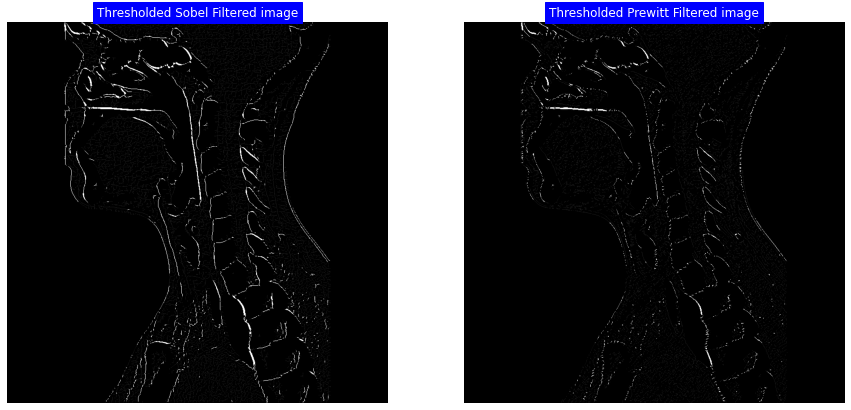

In [174]:
# Plot
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(1, 2)

# original image
ax1 = fig.add_subplot(gs[0, 0])
# ax1.imshow(chest_img, cmap='gray')
ax1.set_title('Thresholded Sobel Filtered image', color='white', backgroundcolor='blue')
plt.axis('off')
plt.imshow(th_sobel_img, cmap='gray', vmin=0, vmax=255)

# filtered image
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Thresholded Prewitt Filtered image', color='white', backgroundcolor='blue')
plt.axis('off')
plt.imshow(th_prewitt_img, cmap='gray', vmin=0, vmax=255)

### 7. Load limbal-dermoid image

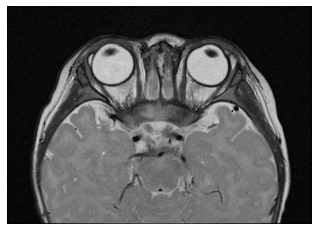

In [175]:
normal_img = cv2.imread('limbal-dermoid.jpeg', 0)
## disable x & y axis
plt.axis('off')
plt.imshow(normal_img, cmap='gray', vmin=normal_img.min(), vmax=normal_img.max())